In [97]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader


def custom_MNIST_loaders(train_batch_size=64, test_batch_size=100, normalize_mean=(0.1307,), normalize_std=(0.3081,), flatten=True):
    transform_list = [ToTensor()]

    if normalize_mean is not None and normalize_std is not None:
        transform_list.append(Normalize(normalize_mean, normalize_std))

    if flatten:
        transform_list.append(Lambda(lambda x: torch.flatten(x)))

    transform = Compose(transform_list)

    train_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader


In [98]:
def insert_y_in_x(original_tensor, indices):
    ### features[:10] includes the one hot map of y 
    modified_tensor = original_tensor.clone()
    modified_tensor[:, :10] *= 0.0
    modified_tensor[range(original_tensor.shape[0]), indices] = original_tensor.max()
    return modified_tensor

In [99]:
### Load and code the data 

train_loader, test_loader = MNIST_loaders()

x_train, y_train = next(iter(train_loader))

### Take 20000 data on train set and 5000 data on test data.
x_train = x_train[:20000]
y_train = y_train[:20000]
x_test = x_test[:5000]
y_test = y_test[:5000]

### creative positive data and negative data 
positive_data = insert_y_in_x(x_train, y_train)
negative_data = insert_y_in_x(x_train, y_train[torch.randperm(x_train.size(0))])

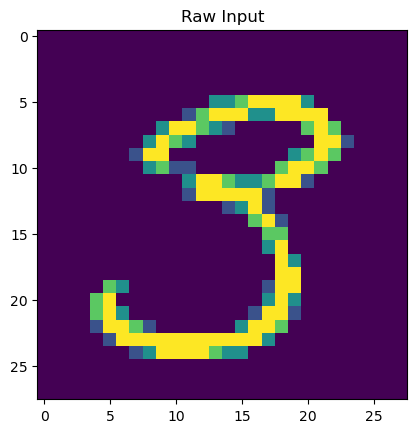

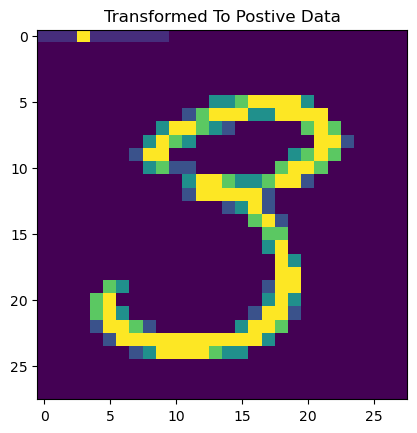

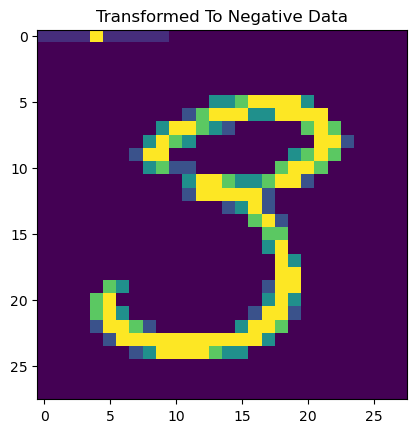

In [100]:
import matplotlib.pyplot as plt

### Plot the Raw Input
plt.title("Raw Input")
plt.imshow(x_train[1].reshape(28,28))
plt.show()

    
### Plot the Positive Input

plt.title("Transformed To Postive Data")
plt.imshow(positive_data[1].reshape(28,28))
plt.show()


### Plot the Negative Input

plt.title("Transformed To Negative Data")
plt.imshow(negative_data[1].reshape(28,28))
plt.show()

In [101]:
from tqdm import tqdm
from torch.optim import Adam

### define a model with two layer and predict and train function.
class ForwardForwadNetwork(torch.nn.Module):

    def __init__(self, input_dim = 28 * 28, dims = [400, 400], dtype=torch.float64):
        super().__init__()
        self.layers = [Layer(input_dim, dims[0]), Layer(dims[0], dims[1])]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = insert_y_in_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [torch.square(h).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            h_pos, h_neg = layer.train(h_pos, h_neg)


class Layer(torch.nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=torch.float64):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000
        
    def forward(self, x):
        normalized_x = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        linear_out = torch.mm(normalized_x, self.weight.T) + self.bias.unsqueeze(0)
        return torch.max(torch.zeros_like(linear_out), linear_out)

    def train(self, pos, neg):
        for i in tqdm(range(self.num_epochs)):
            positive_goodness = torch.square(self.forward(pos)).mean(1)
            negative_goodness = torch.square(self.forward(neg)).mean(1)
            power = [-positive_goodness + self.threshold, negative_goodness - self.threshold]
            loss = torch.log(1 + torch.exp(torch.cat(power))).mean()
            
            ### update the self.params
            
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(pos).detach(), self.forward(neg).detach()



 with the objctive loss function definition the loss decrease if positive data goodness goes upper of threshhold and the negative data goodness goes below the threshhold as we wanted.  
 So it is Logical that we have such a loss function. 

In [102]:
ffnet = ForwardForwadNetwork()
ffnet.train(positive_data, negative_data)

x_test, y_test = next(iter(test_loader))

### predict values

y_hat_train =  ffnet.predict(x_train)
y_hat_test = ffnet.predict(x_test)

### calculate accuracy on train and validation datasets.

train_result = [int(value) for value in list(y_hat_train == y_train)]
train_accuray = sum(train_result)/ len(train_result)


test_result = [int(value) for value in list(y_hat_test == y_test)]
test_accuray = sum(test_result)/ len(test_result)



print('The train accuracy is  ', train_accuray)
print('The validation accuracy is ', test_accuray)


100%|███████████████████████████████████████| 1000/1000 [07:13<00:00,  2.31it/s]


The train accuracy is   0.92745
The validation accuracy is  0.9191


گزارش نحوه پیاده سازی شبکه فوروارد فوروارد:
پس از لود داده های آموزش و تست به دنبال تولید دیتا هایی مثبت و منفی هستیم به گونه ای در صورت یادگیری شبکه در تابع پیش بینی بیشترین گودنس برای تمامی حالت های یک ورودی اصلاح شده بیان گر لیبل آن ورودی است.
همانطور که در بالا توضیح داده شده با تعریف تابع خطا مناسب می توان در جهتی حرکت نمود که یک داده با لیبل درست بیشترین  گود نس را داشته باشد و به طور مشابه داده هایی که به صورت اشتباه کد شده اند کمترین مقدار را داشته باشند.